In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [8]:
DATA_DIR = Path("../2024_data")
FILES = [DATA_DIR / f"2024{m:02d}-bluebikes-tripdata.csv" for m in range(1, 13)]
STATION = "MIT at Mass Ave / Amherst St"
CHUNKSIZE = 500_000
usecols = ["started_at", "ended_at", "start_station_name", "end_station_name"]

missing = [f for f in FILES if not f.exists()]
if missing:
    raise SystemExit(f"Missing files: {', '.join(str(f) for f in missing)}")

def count_hours(series):
    hours = pd.to_datetime(series, errors="coerce").dt.hour.dropna().astype(int)
    return hours.value_counts()

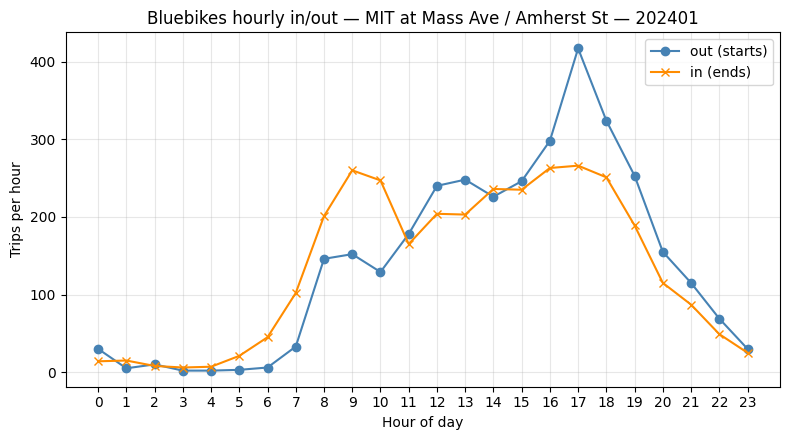

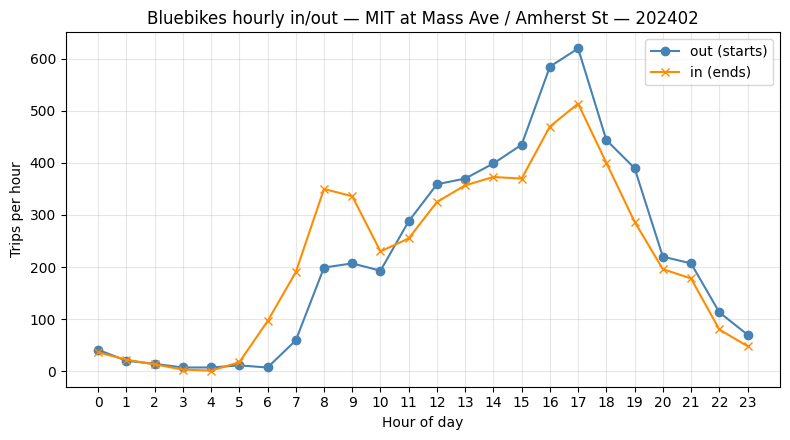

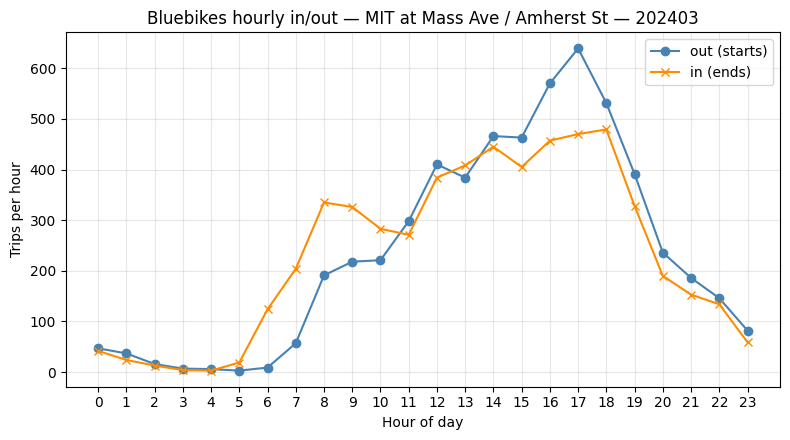

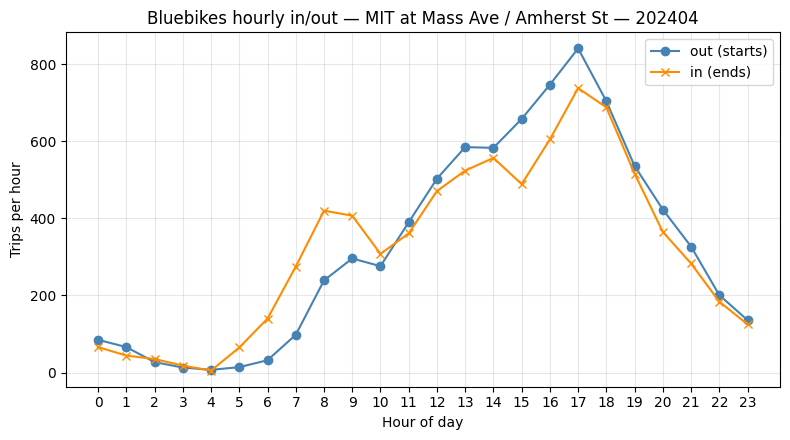

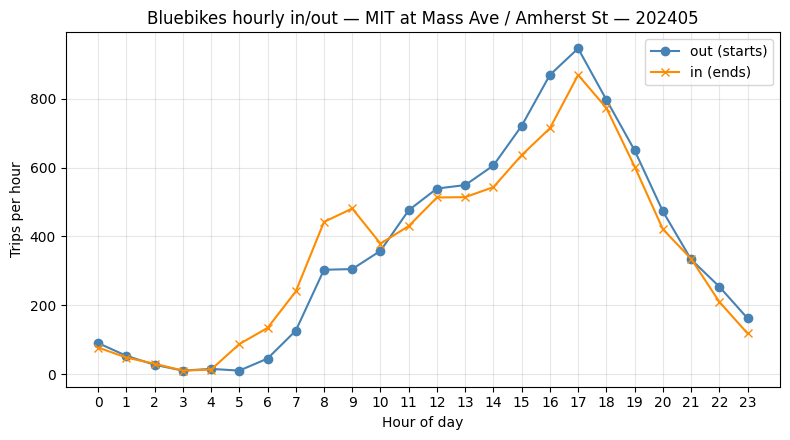

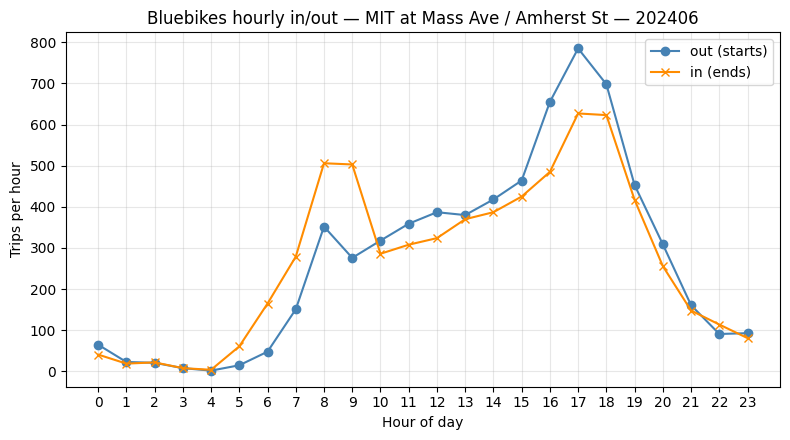

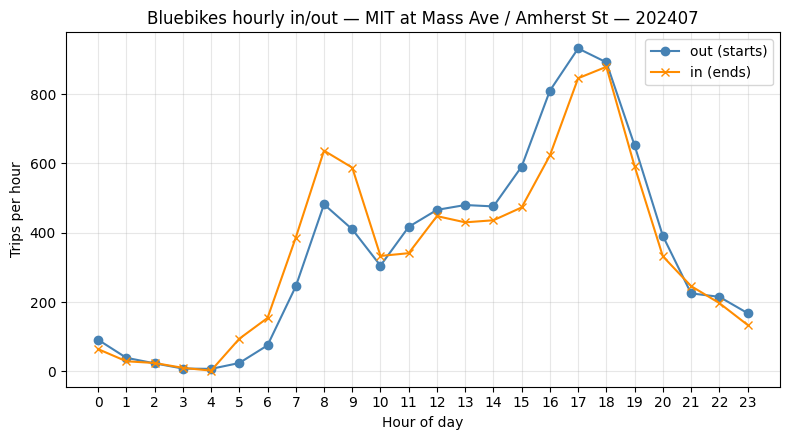

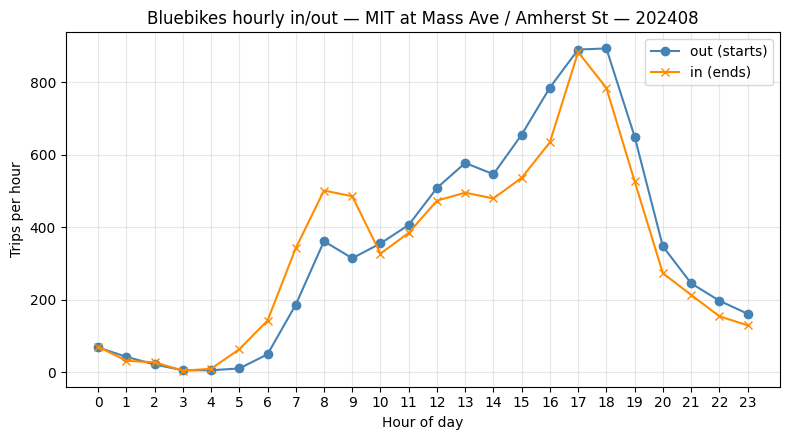

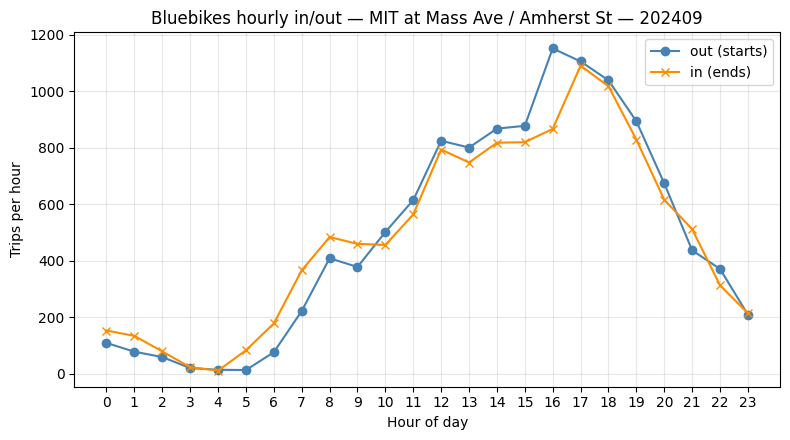

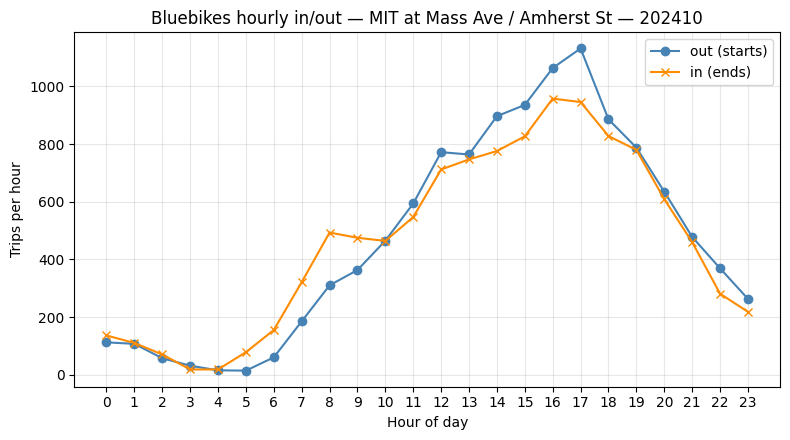

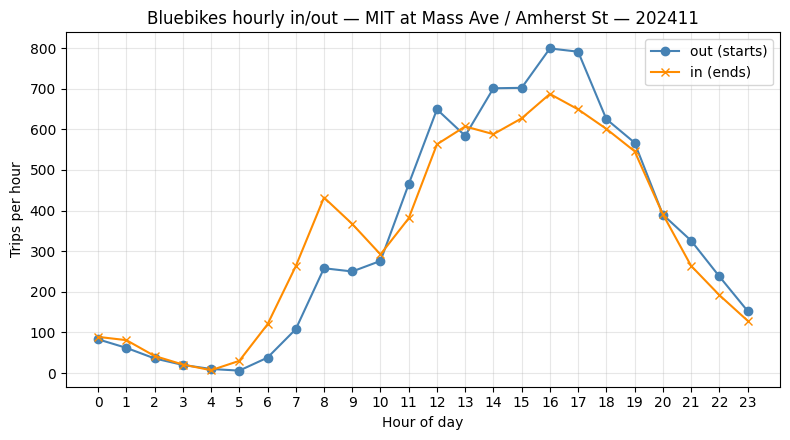

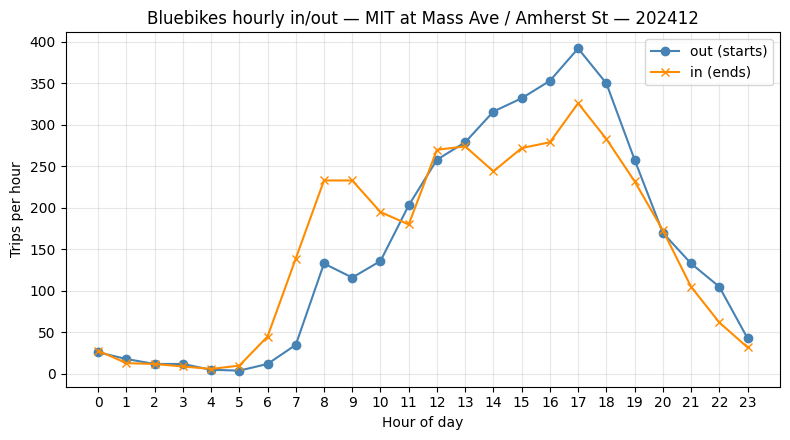

In [9]:
# Aggregate and plot each month inline
for f in FILES:
    month_label = f.stem.split("-")[0]  # e.g., 202409
    out_counts = {h: 0 for h in range(24)}
    in_counts = {h: 0 for h in range(24)}

    for chunk in pd.read_csv(f, usecols=usecols, chunksize=CHUNKSIZE):
        for h, cnt in count_hours(chunk.loc[chunk["start_station_name"] == STATION, "started_at"]).items():
            out_counts[int(h)] += int(cnt)
        for h, cnt in count_hours(chunk.loc[chunk["end_station_name"] == STATION, "ended_at"]).items():
            in_counts[int(h)] += int(cnt)

    hours = list(range(24))
    plt.figure(figsize=(8, 4.5))
    plt.plot(hours, [out_counts[h] for h in hours], label="out (starts)", color="steelblue", marker="o")
    plt.plot(hours, [in_counts[h] for h in hours], label="in (ends)", color="darkorange", marker="x")
    plt.title(f"Bluebikes hourly in/out — {STATION} — {month_label}")
    plt.xlabel("Hour of day")
    plt.ylabel("Trips per hour")
    plt.xticks(hours)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Poisson Prompt


In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path
from collections import defaultdict

DATA_DIR = Path("../2024_data")
FILES = [DATA_DIR / f"2024{m:02d}-bluebikes-tripdata.csv" for m in range(1, 13)]
STATION = "MIT at Mass Ave / Amherst St"
CHUNKSIZE = 500_000
usecols = ["started_at", "ended_at", "start_station_name", "end_station_name"]

missing = [f for f in FILES if not f.exists()]
if missing:
    raise SystemExit(f"Missing files: {', '.join(str(f) for f in missing)}")

# aggregate counts by date and hour (not by month)
out_counts = defaultdict(int)
in_counts = defaultdict(int)

def add_counts(counts, dt_series, station_mask):
    tmp = pd.DataFrame({"date": dt_series.dt.date, "hour": dt_series.dt.hour})
    tmp = tmp.loc[station_mask].dropna()
    tmp["hour"] = tmp["hour"].astype(int)
    for (d, h), c in tmp.groupby(["date", "hour"]).size().items():
        counts[(d, h)] += int(c)

for f in FILES:
    for chunk in pd.read_csv(f, usecols=usecols, chunksize=CHUNKSIZE):
        started_dt = pd.to_datetime(chunk["started_at"], errors="coerce")
        ended_dt = pd.to_datetime(chunk["ended_at"], errors="coerce")
        add_counts(out_counts, started_dt, chunk["start_station_name"] == STATION)
        add_counts(in_counts, ended_dt, chunk["end_station_name"] == STATION)

df_out = pd.DataFrame([(pd.to_datetime(d), h, c) for (d, h), c in out_counts.items()], columns=["date", "hour", "out"])
df_in = pd.DataFrame([(pd.to_datetime(d), h, c) for (d, h), c in in_counts.items()], columns=["date", "hour", "in"])

df_hourly = (
    pd.merge(df_out, df_in, on=["date", "hour"], how="outer")
    .fillna(0)
    .sort_values(["date", "hour"])
    .reset_index(drop=True)
)
df_hourly["dow"] = df_hourly["date"].dt.dayofweek
df_hourly["month"] = df_hourly["date"].dt.month

df_hourly.head()


,hour,out,in
0,0,847,816
1,1,550,570
2,2,323,375
3,3,143,134
4,4,95,86


In [14]:
# one-hot encode hour/day-of-week/month and train Poisson models on daily-hourly counts
feature_cols = pd.get_dummies(
    df_hourly[["hour", "dow", "month"]].astype(int),
    columns=["hour", "dow", "month"],
    prefix=["h", "dow", "m"],
    drop_first=True,
).astype(float)

X_full = sm.add_constant(feature_cols)

split_date = df_hourly["date"].max() - pd.Timedelta(days=7)
train_mask = df_hourly["date"] < split_date
test_mask = ~train_mask

y_out = df_hourly["out"].astype(float)
y_in = df_hourly["in"].astype(float)

model_out = sm.GLM(y_out[train_mask], X_full.loc[train_mask], family=sm.families.Poisson()).fit()
model_in = sm.GLM(y_in[train_mask], X_full.loc[train_mask], family=sm.families.Poisson()).fit()

df_hourly["out_hat"] = model_out.predict(X_full)
df_hourly["in_hat"] = model_in.predict(X_full)

print(model_out.summary().tables[1])
print(model_in.summary().tables[1])


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    out   No. Observations:                   24
Model:                            GLM   Df Residuals:                        0
Model Family:                 Poisson   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -113.11
Date:                Sat, 06 Dec 2025   Deviance:                  -2.6779e-13
Time:                        14:22:27   Pearson chi2:                 1.99e-24
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7417      0.034    196.205      0.0

/Users/kerwin/Desktop/bluebikes-demand-forecast/venv/lib/python3.12/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid
/Users/kerwin/Desktop/bluebikes-demand-forecast/venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/kerwin/Desktop/bluebikes-demand-forecast/venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/Users/kerwin/Desktop/bluebikes-demand-forecast/venv/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or predictio

In [19]:
out_mae_train = (df_hourly.loc[train_mask, "out_hat"] - df_hourly.loc[train_mask, "out"]).abs().mean()
in_mae_train = (df_hourly.loc[train_mask, "in_hat"] - df_hourly.loc[train_mask, "in"]).abs().mean()

out_mae_test = (df_hourly.loc[test_mask, "out_hat"] - df_hourly.loc[test_mask, "out"]).abs().mean()
in_mae_test = (df_hourly.loc[test_mask, "in_hat"] - df_hourly.loc[test_mask, "in"]).abs().mean()

{
    "train_mae": {"out": out_mae_train, "in": in_mae_train},
    "test_mae": {"out": out_mae_test, "in": in_mae_test},
}


(np.float64(3.1438673886441393e-10), np.float64(4.050235702379723e-10))

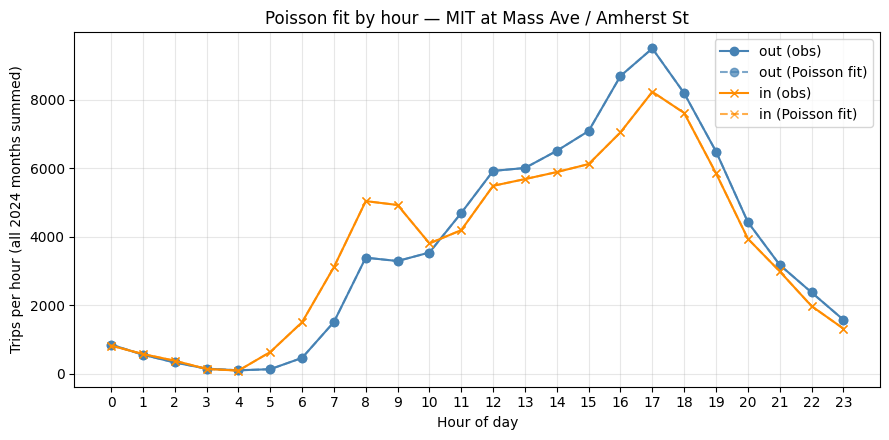

In [18]:
import matplotlib.pyplot as plt

by_hour_test = (
    df_hourly.loc[test_mask]
    .groupby("hour")[['out', 'out_hat', 'in', 'in_hat']]
    .mean()
    .reset_index()
)

plt.figure(figsize=(9, 4.5))
plt.plot(by_hour_test["hour"], by_hour_test["out"], "o-", label="out actual", color="steelblue")
plt.plot(by_hour_test["hour"], by_hour_test["out_hat"], "o--", label="out predicted", color="steelblue", alpha=0.7)
plt.plot(by_hour_test["hour"], by_hour_test["in"], "x-", label="in actual", color="darkorange")
plt.plot(by_hour_test["hour"], by_hour_test["in_hat"], "x--", label="in predicted", color="darkorange", alpha=0.7)
plt.xticks(range(24))
plt.xlabel("Hour of day")
plt.ylabel("Avg trips per hour (last 7 days hold-out)")
plt.title(f"Poisson fit on daily-hourly data — {STATION}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Test


Threshold: 3334.0
Confusion matrix (rows=true, cols=pred):
 [[12 12]
 [ 0  0]]
F1: 0.0


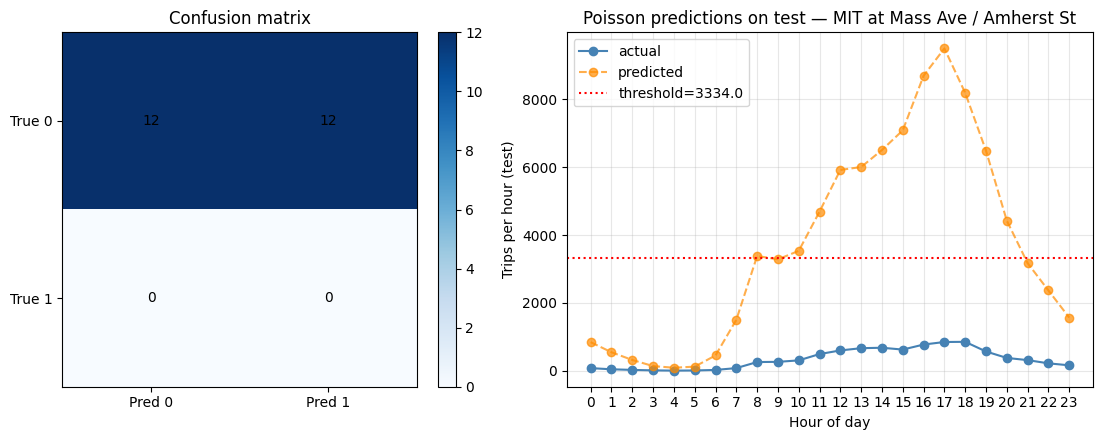

In [23]:
import matplotlib.pyplot as plt

example_date = df_hourly.loc[test_mask, "date"].min()
example_day = df_hourly.loc[df_hourly["date"] == example_date]

plt.figure(figsize=(9, 4))
plt.plot(example_day["hour"], example_day["out"], "o-", label="out actual", color="steelblue")
plt.plot(example_day["hour"], example_day["out_hat"], "o--", label="out predicted", color="steelblue", alpha=0.7)
plt.plot(example_day["hour"], example_day["in"], "x-", label="in actual", color="darkorange")
plt.plot(example_day["hour"], example_day["in_hat"], "x--", label="in predicted", color="darkorange", alpha=0.7)
plt.xticks(range(24))
plt.xlabel("Hour of day")
plt.ylabel("Trips")
plt.title(f"Hold-out day example ({example_date.date()}) — {STATION}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
